# Preparing the data

In [3]:
import pandas as pd
import numpy as np
import ml_utils as mlu
import ml_utils_classification as uc
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [4]:
symbol = 'AAPL'
aapl = yf.Ticker(symbol)

In [5]:
data = aapl.history(start="2014-05-01", end="2025-05-12", actions=False)

YFRateLimitError: Too Many Requests. Rate limited. Try after a while.

In [ ]:
data.index = pd.to_datetime(data.index)

<Axes: xlabel='Date'>

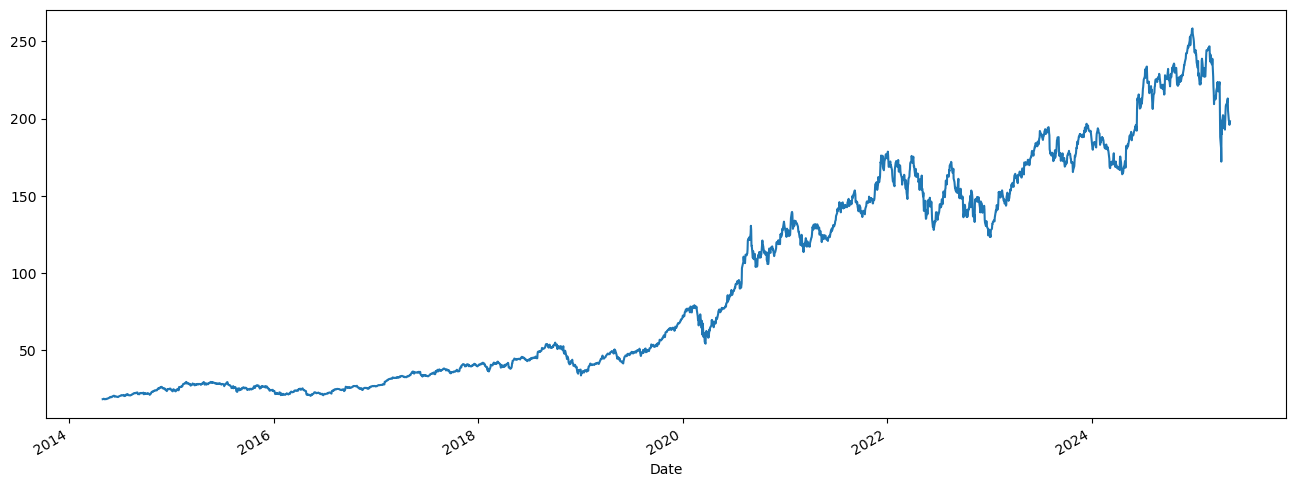

In [ ]:
data['Close'].plot(figsize=(16,6))

In [ ]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2014-05-01 00:00:00-04:00,18.511156,18.598709,18.334801,18.494898,244048000
2014-05-02 00:00:00-04:00,18.521794,18.579954,18.439556,18.529297,191514400
2014-05-05 00:00:00-04:00,18.452995,18.792575,18.448617,18.791323,287067200
2014-05-06 00:00:00-04:00,18.817601,18.899212,18.586525,18.586525,374564400
2014-05-07 00:00:00-04:00,18.612780,18.676569,18.377638,18.521475,282864400
...,...,...,...,...,...
2025-05-05 00:00:00-04:00,202.834025,203.832716,197.950430,198.629532,69018500
2025-05-06 00:00:00-04:00,197.950420,200.387212,196.761976,198.250015,51216500
2025-05-07 00:00:00-04:00,198.909155,199.178806,192.996910,195.992981,68536700


In [ ]:
data['delta'] = data['Close'].diff()

In [ ]:
data['direction'] = (data['delta'] > 0).astype(int)

In [ ]:
data = mlu.calc_all_default(data)

In [ ]:
def direction_momentum(df, horizons=[5, 10, 20, 60]):
    new_df = df.copy()
    for horizon in horizons:
        name = f"direction_mom_{horizon}"
        new_df[name] = new_df['direction'].rolling(horizon).sum() - (horizon/2)
    return new_df

In [ ]:
data = direction_momentum(data)

In [ ]:
data['next_direction'] = data['direction'].shift(-1)

In [ ]:
data['last_close'] = data['Close'].shift(1)

In [ ]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'delta', 'direction',
       'RSI_14', 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'EMA_20',
       'EMA_50', 'EMA_100', 'MACD', 'MACD_Signal', 'BBU_20_2.0', 'BBL_20_2.0',
       'momentum_10', 'ATR_14', 'direction_mom_5', 'direction_mom_10',
       'direction_mom_20', 'direction_mom_60', 'next_direction', 'last_close'],
      dtype='object')

In [ ]:
data = data.dropna()

In [82]:
# Dataset for regression trees
reg_data = data[['next_direction', 'direction', 'direction_mom_5', 'direction_mom_10',
       'direction_mom_20', 'direction_mom_60']]

X = reg_data[['direction', 'direction_mom_5', 'direction_mom_10',
       'direction_mom_20', 'direction_mom_60']]

y = reg_data[['next_direction']]

X_train, X_val, y_train, y_val = uc.split_before_year(X, y, 2022)


# XGB Classification without sentiment

In [83]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

In [128]:
n_estimators = 20000
learning_rate = 0.005
subsample = 0.8
colsample_bytree = 0.8
gamma = 0.1
scale_pos_weight = np.sum(y.values == 0) / np.sum(y.values == 1)

In [129]:
model = XGBClassifier(n_estimators=n_estimators,
                      learning_rate=learning_rate,
                      subsample=subsample,
                      colsample_bytree=colsample_bytree,
                      gamma=gamma,
                      scale_pos_weight=scale_pos_weight,
                      use_label_encoder=False,
                      eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.005, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=20000, n_jobs=None,
              num_parallel_tree=None, ...)

In [130]:
y_train_pred = model.predict(X_train)

print("Accuracy:", accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

Accuracy: 0.8184296619411123
              precision    recall  f1-score   support

         0.0       0.80      0.81      0.81       860
         1.0       0.83      0.82      0.83       974

    accuracy                           0.82      1834
   macro avg       0.82      0.82      0.82      1834
weighted avg       0.82      0.82      0.82      1834



In [131]:
y_pred = model.predict(X_val)

In [132]:
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Accuracy: 0.544047619047619
              precision    recall  f1-score   support

         0.0       0.52      0.53      0.52       397
         1.0       0.57      0.56      0.56       443

    accuracy                           0.54       840
   macro avg       0.54      0.54      0.54       840
weighted avg       0.54      0.54      0.54       840



In [141]:
# Comparison with random model
p = np.mean(y_val.values)
#print(p)
y_random_weighted = np.random.choice([0, 1], size=len(y_val), p=[1 - p, p])

print("Accuracy:", accuracy_score(y_val, y_random_weighted))
print(classification_report(y_val, y_random_weighted))

Accuracy: 0.5095238095238095
              precision    recall  f1-score   support

         0.0       0.48      0.48      0.48       397
         1.0       0.54      0.53      0.53       443

    accuracy                           0.51       840
   macro avg       0.51      0.51      0.51       840
weighted avg       0.51      0.51      0.51       840



# Tests with Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

In [ ]:
# Preparing dataframe for the model
lr_target = data[['next_direction']]
lr_input = data[['direction',
       'RSI_14', 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'EMA_20',
       'EMA_50', 'EMA_100', 'MACD', 'MACD_Signal', 'BBU_20_2.0', 'BBL_20_2.0',
       'momentum_10', 'ATR_14', 'direction_mom_5', 'direction_mom_10',
       'direction_mom_20', 'direction_mom_60', 'last_close']]


In [ ]:
X_train, X_val, y_train, y_val = uc.split_before_year(lr_input, lr_target, 2023)

In [48]:
l1_ratio = 1 # 1->Lasso, 0->Ridge
C = 0.7
max_iter = 10000

poly_degree = 3

In [49]:
# Creating the model
lr_model = Pipeline([
    #('poly', PolynomialFeatures(degree=poly_degree, include_bias=False)),
    ('scaler', RobustScaler()),
    ('class', LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        l1_ratio=l1_ratio,
        C=C,
        max_iter=max_iter
    ))
])

lr_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('class',
                 LogisticRegression(C=0.7, l1_ratio=1, max_iter=10000,
                                    penalty='elasticnet', solver='saga'))])

In [50]:
y_train_pred = lr_model.predict(X_train)
y_val_pred = lr_model.predict(X_val)

In [51]:
from sklearn.metrics import accuracy_score, classification_report

print("Train set evaluation:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print("\nValidation set evaluation:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Train set evaluation:
Accuracy: 0.5328537170263788
              precision    recall  f1-score   support

         0.0       0.52      0.23      0.32       994
         1.0       0.54      0.81      0.64      1091

    accuracy                           0.53      2085
   macro avg       0.53      0.52      0.48      2085
weighted avg       0.53      0.53      0.49      2085


Validation set evaluation:
Accuracy: 0.4533106960950764
              precision    recall  f1-score   support

         0.0       0.40      0.47      0.44       263
         1.0       0.51      0.44      0.47       326

    accuracy                           0.45       589
   macro avg       0.46      0.46      0.45       589
weighted avg       0.46      0.45      0.45       589



# Feature analysis with Lasso

## With PolynomialFeatures and grid search (Too much training time)

In [52]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

In [53]:
# Preparing dataframe for the model
lasso_target = data[['next_direction']]
lasso_input = data[['direction',
       'RSI_14', 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'EMA_20',
       'EMA_50', 'EMA_100', 'MACD', 'MACD_Signal', 'BBU_20_2.0', 'BBL_20_2.0',
       'momentum_10', 'ATR_14', 'direction_mom_5', 'direction_mom_10',
       'direction_mom_20', 'direction_mom_60', 'last_close']]

In [54]:
X_train, X_val, y_train, y_val = uc.split_before_year(lr_input, lr_target, 2023)

In [ ]:
lasso = Pipeline([
    ('poly', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('lasso', LogisticRegressionCV(penalty='l1',
                                   solver='saga',
                                   Cs=10,
                                   cv=5,
                                   max_iter=1000,
                                   scoring='accuracy'))
])

lasso.fit(X_train, y_train)

In [ ]:
y_train_pred = lasso.predict(X_train)
y_val_pred = lasso.predict(X_val)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

print("Train set evaluation:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print("\nValidation set evaluation:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

## Simple Lasso testing

In [23]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

In [24]:
apple = pd.read_csv("datasets/apple_2014-2024_fullSimpleFeatures.csv")

In [25]:
def direction_momentum(df, horizons=[5, 10, 20, 60]):
    new_df = df.copy()
    for horizon in horizons:
        name = f"direction_mom_{horizon}"
        new_df[name] = new_df['direction'].rolling(horizon).sum() - (horizon/2)
    return new_df

In [26]:
apple = apple.set_index(['date']).sort_index()
apple = apple.dropna()
apple.index = pd.to_datetime(apple.index)

In [27]:
data = apple
data['delta'] = data['Close'].diff()
data['direction'] = (data['delta'] > 0).astype(int)
data = direction_momentum(data)
data['next_direction'] = data['direction'].shift(-1)
data['last_close'] = data['Close'].shift(1)
data = data.dropna()

In [28]:
# Preparing dataframe for the model
lasso_target = data[['next_direction']]
lasso_input = data[['direction',
       'RSI_14', 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'EMA_20',
       'EMA_50', 'EMA_100', 'MACD', 'MACD_Signal', 'BBU_20_2.0', 'BBL_20_2.0',
       'momentum_10', 'ATR_14', 'direction_mom_5', 'direction_mom_10',
       'direction_mom_20', 'direction_mom_60', 'last_close']]

In [29]:
X_train, X_val, y_train, y_val = uc.split_before_year(lasso_input, lasso_target, 2023)

In [30]:
lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LogisticRegression(penalty='l1',
                                solver='saga',
                                C=1,
                                max_iter=1000))
])

lasso.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso',
                 LogisticRegression(C=1, max_iter=1000, penalty='l1',
                                    solver='saga'))])

In [31]:
y_train_pred = lasso.predict(X_train)
y_val_pred = lasso.predict(X_val)

In [32]:
from sklearn.metrics import accuracy_score, classification_report

print("Train set evaluation:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print("\nValidation set evaluation:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Train set evaluation:
Accuracy: 0.5319465081723626
              precision    recall  f1-score   support

         0.0       0.52      0.25      0.33       963
         1.0       0.54      0.79      0.64      1056

    accuracy                           0.53      2019
   macro avg       0.53      0.52      0.49      2019
weighted avg       0.53      0.53      0.49      2019


Validation set evaluation:
Accuracy: 0.45617529880478086
              precision    recall  f1-score   support

         0.0       0.39      0.40      0.39       221
         1.0       0.51      0.50      0.51       281

    accuracy                           0.46       502
   macro avg       0.45      0.45      0.45       502
weighted avg       0.46      0.46      0.46       502



In [33]:
feature_analyzer = lasso.named_steps['lasso']
coefs = feature_analyzer.coef_[0]
selected = [i for i, w in enumerate(coefs) if w != 0]

print("Feature selezionate:", selected)

Feature selezionate: [0, 1, 6, 10, 11, 13, 14, 15, 16, 17, 18, 19]


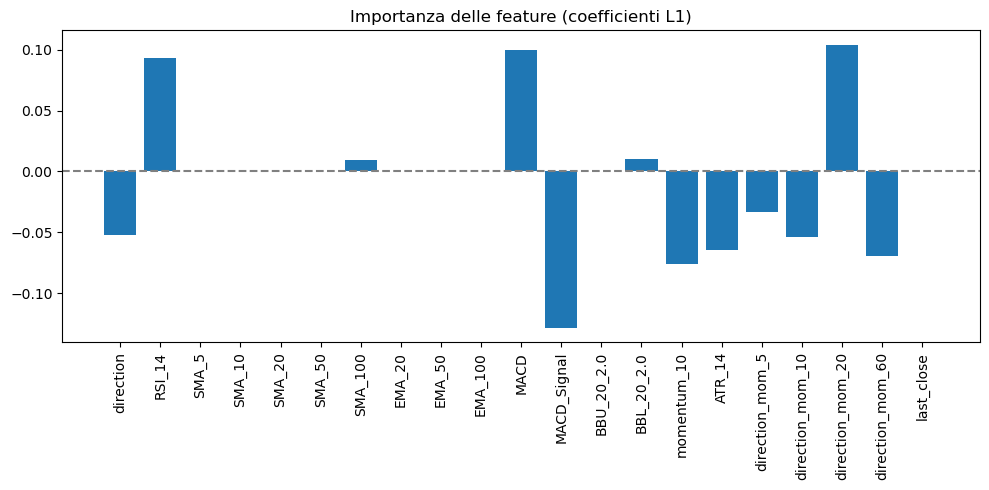

In [35]:
import matplotlib.pyplot as plt
import numpy as np

feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"f{i}" for i in range(X_train.shape[1])]
coefs = feature_analyzer.coef_[0]

plt.figure(figsize=(10, 5))
plt.bar(feature_names, coefs)
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=90)
plt.title("Importanza delle feature (coefficienti L1)")
plt.tight_layout()
plt.show()

### Rebuilding with best features

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [37]:
def direction_momentum(df, horizons=[5, 10, 20, 60]):
    new_df = df.copy()
    for horizon in horizons:
        name = f"direction_mom_{horizon}"
        new_df[name] = new_df['direction'].rolling(horizon).sum() - (horizon/2)
    return new_df

In [39]:
apple = pd.read_csv("datasets/apple_2014-2024_fullSimpleFeatures.csv")

apple = apple.set_index(['date']).sort_index()
apple = apple.dropna()
apple.index = pd.to_datetime(apple.index)

data = apple
data['delta'] = data['Close'].diff()
data['direction'] = (data['delta'] > 0).astype(int)
data = direction_momentum(data)
data['next_direction'] = data['direction'].shift(-1)
data['last_close'] = data['Close'].shift(1)
data = data.dropna()

In [40]:
# Preparing dataframe for the model
lasso_target = data[['next_direction']]
lasso_input = data[['direction','RSI_14', 'MACD', 'MACD_Signal',
       'momentum_10', 'ATR_14', 'direction_mom_5', 'direction_mom_10',
       'direction_mom_20', 'direction_mom_60']]

X_train, X_val, y_train, y_val = uc.split_before_year(lasso_input, lasso_target, 2023)

In [41]:
lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LogisticRegression(penalty='l1',
                                solver='saga',
                                C=1,
                                max_iter=1000))
])

lasso.fit(X_train, y_train)

y_train_pred = lasso.predict(X_train)
y_val_pred = lasso.predict(X_val)

In [42]:
from sklearn.metrics import accuracy_score, classification_report

print("Train set evaluation:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print("\nValidation set evaluation:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Train set evaluation:
Accuracy: 0.5289747399702823
              precision    recall  f1-score   support

         0.0       0.51      0.25      0.34       963
         1.0       0.53      0.78      0.64      1056

    accuracy                           0.53      2019
   macro avg       0.52      0.52      0.49      2019
weighted avg       0.52      0.53      0.49      2019


Validation set evaluation:
Accuracy: 0.45219123505976094
              precision    recall  f1-score   support

         0.0       0.40      0.47      0.43       221
         1.0       0.51      0.44      0.47       281

    accuracy                           0.45       502
   macro avg       0.45      0.45      0.45       502
weighted avg       0.46      0.45      0.45       502



In [44]:
feature_analyzer = lasso.named_steps['lasso']
coefs = feature_analyzer.coef_[0]
selected = [i for i, w in enumerate(coefs) if w != 0]

print("Feature selezionate:", selected)

Feature selezionate: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


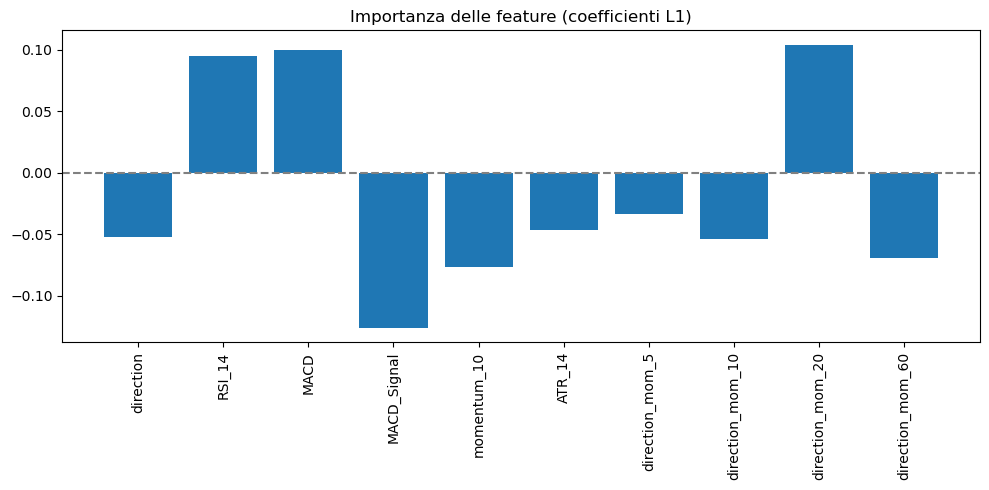

In [45]:
import matplotlib.pyplot as plt
import numpy as np

feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"f{i}" for i in range(X_train.shape[1])]
coefs = feature_analyzer.coef_[0]

plt.figure(figsize=(10, 5))
plt.bar(feature_names, coefs)
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=90)
plt.title("Importanza delle feature (coefficienti L1)")
plt.tight_layout()
plt.show()

In [51]:
# Trying a random forest model with chosen features
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(
    n_estimators=5000,
    min_samples_split=5,
    min_samples_leaf=5,
    max_features=0.8,
    max_depth=None,
    random_state=42
)

rfc.fit(X_train, y_train)

y_train_pred = rfc.predict(X_train)
y_val_pred = rfc.predict(X_val)

In [52]:
print("Train set evaluation:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print("\nValidation set evaluation:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Train set evaluation:
Accuracy: 0.9683011391778108
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97       963
         1.0       0.96      0.98      0.97      1056

    accuracy                           0.97      2019
   macro avg       0.97      0.97      0.97      2019
weighted avg       0.97      0.97      0.97      2019


Validation set evaluation:
Accuracy: 0.4701195219123506
              precision    recall  f1-score   support

         0.0       0.42      0.50      0.45       221
         1.0       0.53      0.45      0.49       281

    accuracy                           0.47       502
   macro avg       0.47      0.47      0.47       502
weighted avg       0.48      0.47      0.47       502



### Trying best features with LSTM -> Better than expected

In [110]:
from sklearn.preprocessing import RobustScaler

lstm_input = lasso_input
lstm_target = lasso_target

input_scaler = RobustScaler()
scaled_input = input_scaler.fit_transform(lstm_input)

X_train, X_val, y_train, y_val, input_size, train_size = mlu.train_test_split_timeWindows(scaled_input,
                                                                                          lstm_target.values,
                                                                                          window_size=5,
                                                                                          train_size_pct=0.9)

In [111]:
window_size = 10
lstm_units = [150, 100, 50]
dense_units = [50, 25]
dropout = 0

epochs = 50
batch_size = 16
set_early_stopping = True

In [112]:
import ml_utils as mlu
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
import warnings
warnings.filterwarnings('ignore')

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=20,
    restore_best_weights=True    
)

lstm_model = Sequential()
lstm_model.add(Input(shape=input_size))
lstm_model.add(LSTM(units=lstm_units[0], return_sequences=True))
for u in lstm_units[1:]:
            rs = (u != lstm_units[-1]) #return_sequences is False in the last LSTM layer.
            lstm_model.add(LSTM(units=u, return_sequences=rs))
for d in dense_units:
            lstm_model.add(Dense(units=d, activation='relu'))
lstm_model.add(Dense(units=1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [113]:
lstm_model.fit(X_train, y_train,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(X_val, y_val),
               callbacks=[early_stopping])

Epoch 1/50


142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5033 - loss: 0.6948 - val_accuracy: 0.5317 - val_loss: 0.6920
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5246 - loss: 0.6925 - val_accuracy: 0.4524 - val_loss: 0.6974
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5253 - loss: 0.6911 - val_accuracy: 0.5675 - val_loss: 0.6876
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5474 - loss: 0.6893 - val_accuracy: 0.5159 - val_loss: 0.6933
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5286 - loss: 0.6912 - val_accuracy: 0.4683 - val_loss: 0.6978
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5305 - loss: 0.6904 - val_accuracy: 0.4444 - val_loss: 0.7001
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5097 - loss: 0.6939 - val_accuracy: 0.4405 - val_loss: 0.6997
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5342 - loss: 0.6893 - val_accuracy: 0.50

In [114]:
y_train_pred = (lstm_model.predict(X_train) >= 0.5).astype(int)
y_val_pred = (lstm_model.predict(X_val) >= 0.5).astype(int)

print("Train set evaluation:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print("\nValidation set evaluation:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Train set evaluation:
Accuracy: 0.5167844522968198
              precision    recall  f1-score   support

         0.0       0.46      0.13      0.20      1070
         1.0       0.53      0.87      0.65      1194

    accuracy                           0.52      2264
   macro avg       0.49      0.50      0.43      2264
weighted avg       0.49      0.52      0.44      2264


Validation set evaluation:
Accuracy: 0.5674603174603174
              precision    recall  f1-score   support

         0.0       0.54      0.06      0.11       110
         1.0       0.57      0.96      0.71       142

    accuracy                           0.57       252
   macro avg       0.55      0.51      0.41       252
weighted avg       0.56      0.57      0.45       252

